In [1]:
# Start loading libraries

#! pip install yfinance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#! pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection

import scipy
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_acf

#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [2]:
xls_file = pd.ExcelFile("sbo_interpolated.xlsx") # Read Excel
df1=xls_file.parse("Sheet1") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df1 = df1.set_index(['Timestamp']) # use first column as index

#df1.to_excel("values.xlsx")  #print to excel


df1.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,29.675727,29.723833,29.767834,29.813131,29.904571,29.922280,29.934232,29.936104,29.963668,29.989095,29.971150,29.961392,29.942654,29.924029,29.887939,29.843596,29.797980,29.752120,29.687518
std,13.161684,13.001273,12.842833,12.707434,12.666739,12.565280,12.474697,12.387599,12.329806,12.278305,12.215360,12.167823,12.143366,12.112777,12.074348,12.057817,12.052729,12.080655,12.115200
min,13.560000,13.798924,14.008234,14.230000,14.378293,14.539042,14.683604,14.811979,14.900000,15.020168,15.099982,15.163609,15.220000,12.821429,9.740000,6.434286,2.904286,-0.850000,-4.828571
25%,20.760674,20.908079,21.059999,21.167519,21.267486,21.359170,21.403471,21.430000,21.495582,21.455204,21.474687,21.541627,21.492857,21.449141,21.360241,21.402031,21.315556,21.087863,21.093847
50%,26.074432,25.942968,25.856100,25.890000,26.020000,26.030000,25.940341,25.820000,25.834432,25.842795,25.777620,25.712117,25.730000,25.500000,25.333833,25.222727,25.120685,25.083864,25.101750
75%,33.385824,33.492957,33.527892,33.529540,33.617991,33.615162,33.727591,33.922146,34.034049,34.189761,34.118249,34.091162,34.005000,34.137149,34.131263,34.107760,34.098004,34.084343,34.130815
max,89.170000,85.807009,83.631193,79.950000,79.792559,78.129741,76.637922,75.340000,74.167283,73.510307,73.039018,72.569016,72.610000,72.330000,71.166737,70.906525,70.430000,71.513874,72.074047


<AxesSubplot:xlabel='Timestamp'>

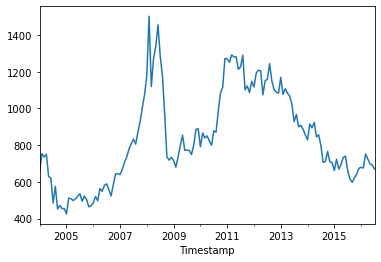

In [3]:
spot = df1[1]
spot = spot.loc['2004-01-31':'2022-11-30']*22.04623
#spot = np.log(spot)
spot_train = spot.loc[:'2016-07-31']
spot_train.plot()

In [25]:
#statistics

#mean
#sd
#skewness
#kurtosis
#jb test
#Ljung Box Q(6) and Q^2(6)
#observations

spot_train.describe()
#spot.dropna().describe()

count    151.000000
mean       6.685402
std        0.306107
min        6.053022
25%        6.491561
50%        6.673513
75%        6.981589
max        7.314853
Name: 1, dtype: float64

In [26]:
print("Skewness spot:", scipy.stats.skew(spot_train.dropna(), axis=0, bias=True))
print("Skewness logs:", scipy.stats.skew(np.log(spot_train.dropna()), axis=0, bias=True))
print("Kurtosis spot:", scipy.stats.kurtosis(spot_train.dropna(), axis=0, fisher=False, bias=True))
print("Kurtosis logs:", scipy.stats.kurtosis(np.log(spot_train.dropna()), fisher=False, axis=0, bias=True))

print("JB spot:", scipy.stats.jarque_bera(spot_train.dropna()))
print("JB logs:", scipy.stats.jarque_bera(np.log(spot_train.dropna())))
#The Jarque-Bera Test is typically used for large datasets (n > 2000) in which other normality tests (like the Shapiro-Wilk test) are unreliable.

print("Q(6) spot:", sm.stats.acorr_ljungbox(spot_train.dropna(), lags=[6]))
print("Q(6) logs:", sm.stats.acorr_ljungbox(np.log(spot_train.dropna()), lags=[6]))

Skewness spot: -0.04940800211994622
Skewness logs: -0.1252065235731067
Kurtosis spot: 2.0985075538213276
Kurtosis logs: 2.12625286433331
JB spot: Jarque_beraResult(statistic=5.174601592286793, pvalue=0.07522280799970715)
JB logs: Jarque_beraResult(statistic=5.197802226720265, pvalue=0.07435524131815796)
Q(6) spot:       lb_stat      lb_pvalue
6  713.731905  6.629797e-151
Q(6) logs:       lb_stat      lb_pvalue
6  718.002964  7.929016e-152


In [27]:
#stationarity

#augmented Dickie-Fuller
#PP test - Phillips and Perron
#KPSS

print("ADF spot:", adfuller(spot_train.dropna()))
print("ADF logs:", adfuller(np.log(spot_train.dropna())))

print("PP spot:", PhillipsPerron(spot_train.dropna()).summary().as_text())
print("PP logs:", PhillipsPerron(np.log(spot_train.dropna())).summary().as_text())



ADF spot: (-1.660466225772639, 0.4515878593409928, 0, 150, {'1%': -3.474714913481481, '5%': -2.881008708148148, '10%': -2.5771508444444446}, -317.080824457851)
ADF logs: (-1.6545010121678412, 0.45469408335965605, 0, 150, {'1%': -3.474714913481481, '5%': -2.881008708148148, '10%': -2.5771508444444446}, -839.5659166088581)
PP spot:      Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.789
P-value                         0.386
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
PP logs:      Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.776
P-value                         0.392
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process c

In [28]:

print("KPSS spot:", KPSS(spot_train.dropna()).summary().as_text())
print("KPSS logs:", KPSS(np.log(spot_train.dropna())).summary().as_text())

KPSS spot:     KPSS Stationarity Test Results   
Test Statistic                  0.576
P-value                         0.026
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
KPSS logs:     KPSS Stationarity Test Results   
Test Statistic                  0.589
P-value                         0.024
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


ACF and PACF spot:
ACF and PACF logs:


c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


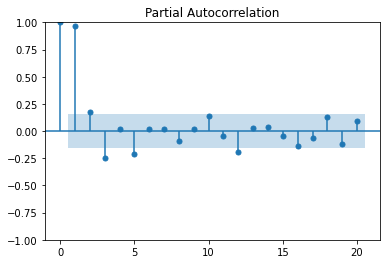

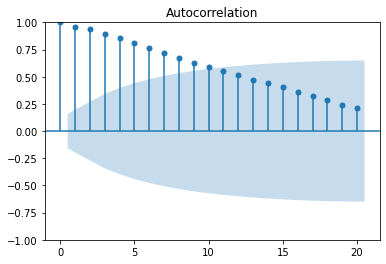

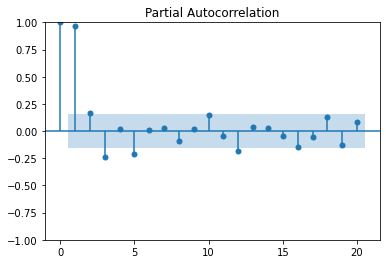

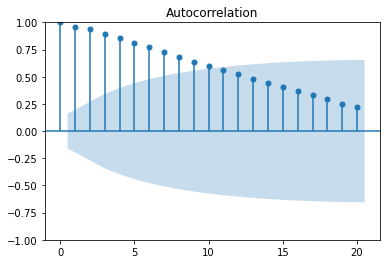

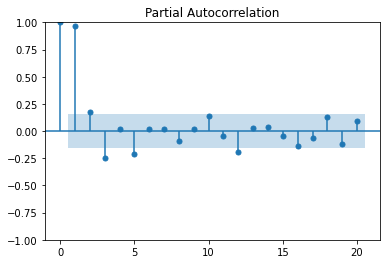

In [29]:
#ACF and PACF

print("ACF and PACF spot:")
plot_acf(spot_train.dropna(), lags = 20)
plot_pacf(spot_train.dropna(), lags = 20)


print("ACF and PACF logs:")
plot_acf(np.log(spot_train.dropna()), lags = 20)
plot_pacf(np.log(spot_train.dropna()), lags = 20)



0.6782943507735172

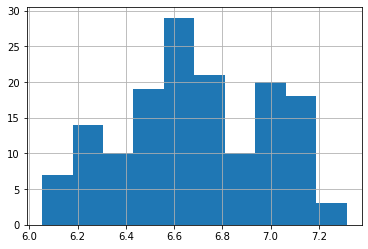

In [30]:
spot_train.hist()
0.6782943507735172

<AxesSubplot:>

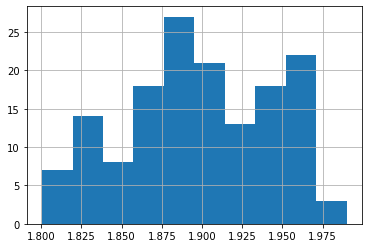

In [31]:
np.log(spot_train).hist()

In [32]:
# Load the data and split it into separate pieces
data = np.array(spot.dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-322.354, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-319.927, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-320.539, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-319.782, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-321.927, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-322.294, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-323.409, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-324.124, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-322.714, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-324.642, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-322.950, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-320.893, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-326.642, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-322.539, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]          

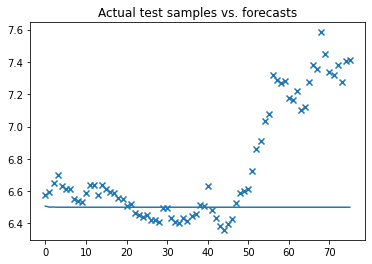

In [33]:
# Fit a simple auto_arima model
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=False)

#arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      #suppress_warnings=True, maxiter=5,
                      #seasonal=True, m=12)

# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

In [34]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  151
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 166.321
Date:                Sat, 07 Jan 2023   AIC                           -326.642
Time:                        14:20:55   BIC                           -317.610
Sample:                             0   HQIC                          -322.973
                                - 151                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1045      0.056     -1.850      0.064      -0.215       0.006
ar.L2          0.2000      0.070      2.870      0.004       0.063       0.337
sigma2         0.0064      0.001     11.312      0.000       0.005       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                25.21
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

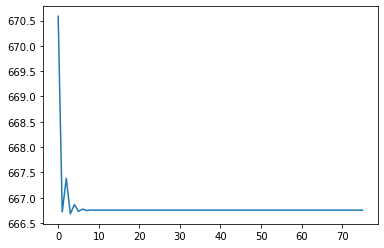

In [49]:
plt.plot(x, arima.predict(n_periods=test.shape[0]))

In [50]:
arima.predict(n_periods=test.shape[0])

array([670.58583025, 666.71993395, 667.38236524, 666.67960988,
       666.86412668, 666.72940497, 666.77416267, 666.74731496,
       666.75753737, 666.75204535, 666.75431049, 666.7531681 ,
       666.75366191, 666.75342182, 666.7535285 , 666.75347773,
       666.75350066, 666.75348988, 666.75349479, 666.7534925 ,
       666.75349355, 666.75349306, 666.75349329, 666.75349318,
       666.75349323, 666.75349321, 666.75349322, 666.75349321,
       666.75349322, 666.75349321, 666.75349322, 666.75349322,
       666.75349322, 666.75349322, 666.75349322, 666.75349322,
       666.75349322, 666.75349322, 666.75349322, 666.75349322,
       666.75349322, 666.75349322, 666.75349322, 666.75349322,
       666.75349322, 666.75349322, 666.75349322, 666.75349322,
       666.75349322, 666.75349322, 666.75349322, 666.75349322,
       666.75349322, 666.75349322, 666.75349322, 666.75349322,
       666.75349322, 666.75349322, 666.75349322, 666.75349322,
       666.75349322, 666.75349322, 666.75349322, 666.75

<AxesSubplot:xlabel='Timestamp'>

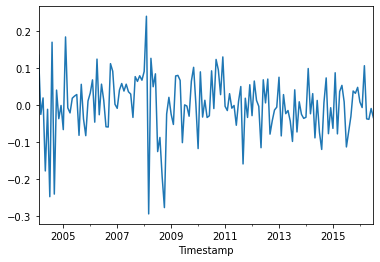

In [51]:
spot2 = np.log(spot).diff()
#spot2 = spot.diff()
spot_train2 = spot2.loc[:'2016-07-31'].dropna()
spot_train2.plot()


In [52]:
#statistics

#mean
#sd
#skewness
#kurtosis
#jb test
#Ljung Box Q(6) and Q^2(6)
#observations

spot_train2.describe()
#spot.dropna().describe()

count    150.000000
mean       0.000110
std        0.082468
min       -0.294218
25%       -0.036043
50%        0.001940
75%        0.055231
max        0.241209
Name: 1, dtype: float64

In [53]:
print("Skewness spot:", scipy.stats.skew(spot_train2.dropna(), axis=0, bias=True))
#print("Skewness logs:", scipy.stats.skew(np.log(spot2.dropna()), axis=0, bias=True))
print("Kurtosis spot:", scipy.stats.kurtosis(spot_train2.dropna(), axis=0, fisher=False, bias=True))
#print("Kurtosis logs:", scipy.stats.kurtosis(np.log(spot2.dropna()), fisher=False, axis=0, bias=True))

print("JB spot:", scipy.stats.jarque_bera(spot_train2.dropna()))
#print("JB logs:", scipy.stats.jarque_bera(np.log(spot2.dropna())))
#The Jarque-Bera Test is typically used for large datasets (n > 2000) in which other normality tests (like the Shapiro-Wilk test) are unreliable.

print("Q(6) spot:", sm.stats.acorr_ljungbox(spot_train2.dropna(), lags=[6]))
#print("Q(6) logs:", sm.stats.acorr_ljungbox(np.log(spot2.dropna()), lags=[6]))

Skewness spot: -0.6883715637374259
Kurtosis spot: 4.902217548158615
JB spot: Jarque_beraResult(statistic=34.461582747323824, pvalue=3.286717575878839e-08)
Q(6) spot:      lb_stat  lb_pvalue
6  18.697229   0.004707


In [54]:
#stationarity

#augmented Dickie-Fuller
#PP test - Phillips and Perron
#KPSS

print("ADF spot:", adfuller(spot_train2.dropna()))
#print("ADF logs:", adfuller(np.log(spot2.dropna())))

print("PP spot:", PhillipsPerron(spot_train2.dropna()).summary().as_text())
#print("PP logs:", PhillipsPerron(np.log(spot2.dropna())).summary().as_text())

ADF spot: (-13.949443883009335, 4.7313366029911366e-26, 0, 149, {'1%': -3.4750180242954167, '5%': -2.8811408028842043, '10%': -2.577221358046935}, -310.29845428599634)
PP spot:      Phillips-Perron Test (Z-tau)    
Test Statistic                -13.813
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [55]:
print("KPSS spot:", KPSS(spot_train2.dropna()).summary().as_text())
#print("KPSS logs:", KPSS(np.log(spot2.dropna())).summary().as_text())

KPSS spot:     KPSS Stationarity Test Results   
Test Statistic                  0.126
P-value                         0.471
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


ACF and PACF spot:


c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


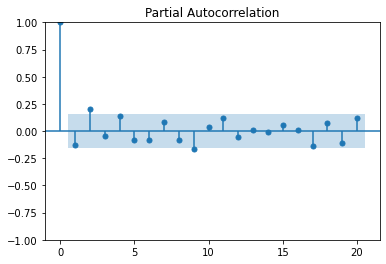

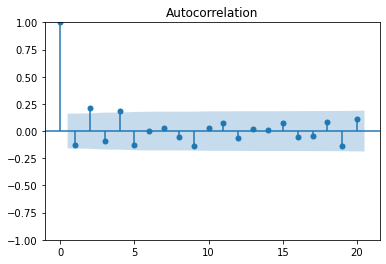

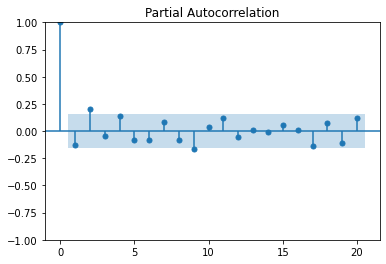

In [56]:
#ACF and PACF

print("ACF and PACF spot:")
plot_acf(spot_train2.dropna(), lags = 20)
plot_pacf(spot_train2.dropna(), lags = 20)


#print("ACF and PACF logs:")
#plot_acf(np.log(spot2.dropna()), lags = 15)
#plot_pacf(np.log(spot2.dropna()), lags = 15)


<AxesSubplot:>

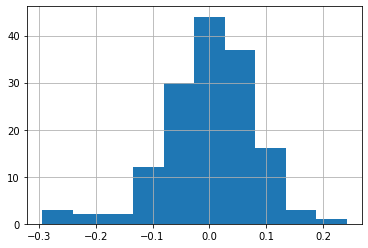

In [57]:
spot_train2.hist()


In [58]:
# Load the data and split it into separate pieces
data2 = np.array(spot2.dropna())
train2, test2 = model_selection.train_test_split(data2, train_size=(spot_train2.shape[0]))

In [59]:
train2

array([ 0.13562507, -0.02466235,  0.01997163, -0.17778618, -0.0108438 ,
       -0.24757005,  0.17089286, -0.24053529,  0.04110898, -0.03624752,
       -0.00048508, -0.06589605,  0.18513363, -0.00689943, -0.02060721,
        0.01923151,  0.02493151,  0.02921744, -0.0813805 ,  0.05681129,
       -0.03715087, -0.08226715,  0.01180651,  0.03325659,  0.06885923,
       -0.04567949,  0.12510244, -0.02566257,  0.05726443,  0.01356464,
       -0.05817161, -0.05881646,  0.1128152 ,  0.09224406,  0.00273785,
       -0.00820294,  0.04147773,  0.05900173,  0.03855986,  0.05715931,
        0.0366505 ,  0.03038276, -0.03284279,  0.07763992,  0.06475624,
        0.07998081,  0.06796985,  0.09174782,  0.24120896, -0.29421768,
        0.12724363,  0.05027156,  0.08525195, -0.12534487, -0.08710501,
       -0.19362111, -0.27707254, -0.02341849,  0.02155845, -0.02426605,
       -0.05185425,  0.07946849,  0.08100621,  0.06750464, -0.10119676,
        0.00114155, -0.00199857, -0.02958452,  0.06528207,  0.10

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-324.300, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-321.927, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-322.539, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-321.782, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-324.297, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-325.407, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-326.399, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-324.715, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-326.642, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-324.951, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-322.894, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-324.642, Time=0.03 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.268 seconds


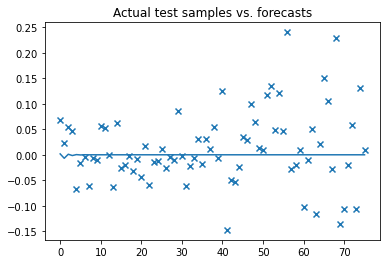

In [60]:
# Fit a simple auto_arima model
arima2 = pm.auto_arima(train2, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=False)

#arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      #suppress_warnings=True, maxiter=5,
                      #seasonal=True, m=12)

# #############################################################################
# Plot actual test vs. forecasts:
x2 = np.arange(test2.shape[0])
plt.scatter(x2, test2, marker='x')
plt.plot(x2, arima2.predict(n_periods=test2.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

In [61]:
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 166.321
Date:                Sun, 01 Jan 2023   AIC                           -326.642
Time:                        21:17:35   BIC                           -317.610
Sample:                             0   HQIC                          -322.973
                                - 150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1045      0.056     -1.850      0.064      -0.215       0.006
ar.L2          0.2000      0.070      2.871      0.004       0.063       0.337
sigma2         0.0064      0.001     11.312      0.000       0.005       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                25.21
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

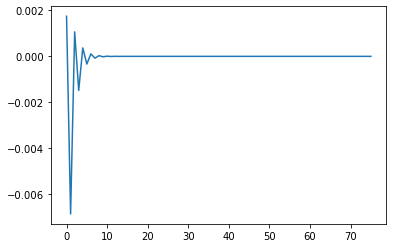

In [62]:
plt.plot(x2, arima2.predict(n_periods=test2.shape[0]))

In [63]:
tests = arima2.predict(n_periods=test2.shape[0])
tests

array([ 1.74572369e-03, -6.85657061e-03,  1.06561626e-03, -1.48252615e-03,
        3.68024075e-04, -3.34932354e-04,  1.08597334e-04, -7.83277877e-05,
        2.99023960e-05, -1.87886943e-05,  7.94325904e-06, -4.58740998e-06,
        2.06786668e-06, -1.13347647e-06,  5.31977538e-07, -2.82262824e-07,
        1.35880635e-07, -7.06460823e-08,  3.45557474e-08, -1.77387878e-08,
        8.76411662e-09, -4.46323002e-09,  2.21904417e-09, -1.12444107e-09,
        5.61265658e-10, -2.83516528e-10,  1.41868654e-10, -7.15225416e-11,
        3.58448146e-11, -1.80487682e-11,  9.05429573e-12, -4.55554313e-12,
        2.28672055e-12, -1.14997390e-12,  5.77467678e-13, -2.90315659e-13,
        1.45819223e-13, -7.32950572e-14,  3.68200722e-14, -1.85051479e-14,
        9.29701818e-15, -4.67217385e-15,  2.34744779e-15, -1.17964355e-15,
        5.92712311e-16, -2.97842022e-16,  1.49654329e-16, -7.52009382e-17,
        3.77861765e-17, -1.89872414e-17,  9.54059722e-18, -4.79403628e-18,
        2.40889303e-18, -

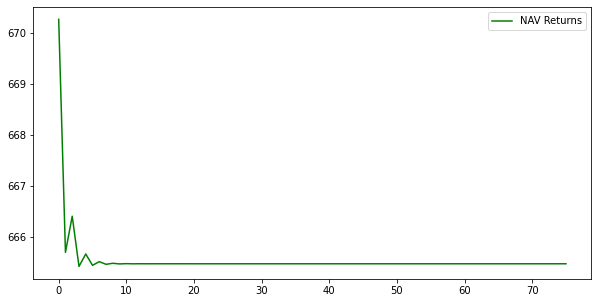

In [64]:
cum_res = np.exp(tests.cumsum())*spot.iloc[spot_train.shape[0]-1]
#cum_res = tests.cumsum()+spot.iloc[spot_train.shape[0]-1]
plt.figure(figsize=(10,5))
plt.plot(cum_res, color='g',label = 'NAV Returns')
plt.legend()
plt.show()

In [65]:
cum_res

array([670.27216975, 665.69212096, 666.4018714 , 665.41464517,
       665.65957885, 665.43666525, 665.50893382, 665.45680802,
       665.47670707, 665.46420375, 665.46948973, 665.46643695,
       665.46781305, 665.46705876, 665.46741277, 665.46722494,
       665.46731536, 665.46726835, 665.46729134, 665.46727954,
       665.46728537, 665.4672824 , 665.46728388, 665.46728313,
       665.4672835 , 665.46728332, 665.46728341, 665.46728336,
       665.46728339, 665.46728337, 665.46728338, 665.46728338,
       665.46728338, 665.46728338, 665.46728338, 665.46728338,
       665.46728338, 665.46728338, 665.46728338, 665.46728338,
       665.46728338, 665.46728338, 665.46728338, 665.46728338,
       665.46728338, 665.46728338, 665.46728338, 665.46728338,
       665.46728338, 665.46728338, 665.46728338, 665.46728338,
       665.46728338, 665.46728338, 665.46728338, 665.46728338,
       665.46728338, 665.46728338, 665.46728338, 665.46728338,
       665.46728338, 665.46728338, 665.46728338, 665.46

In [36]:
#cointegration tests

#normalized cv
#LR test

In [37]:
#correlaatiomatriisi

In [38]:
#np.argwhere(np.isnan(x))